# Sample Lya posterior as a function of nuisance parameters

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
import corner
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler

### Setup Lya likelihood function

In [2]:
# read P1D measurement
data=data_PD2013.P1D_PD2013(blind_data=True)
zs=data.z

In [3]:
basedir='../../p1d_emulator/sim_suites/emulator_512_17052019/'
p1d_label='p1d'
skewers_label='Ns100_wM0.05'
undersample_z=3
use_gp=True
if use_gp:
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,verbose=True,paramList=None,kmax_Mpc=5,train=True)
else:
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,verbose=False)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}, 'mu_H': {'ip': 5, 'min_val': 0.5, 'max_val': 2.0, '   latex': '$\\mu_{\\rm H}$'}}, 'nsamples': 10, 'samples': {'0': [0.972, 0.42000000000000004, -2.315, -0.19, 0.7250000000000001, 1.3250000000000002], '1': [0.96, 0.28, -2.295, -0.2, 1.3250000000000002, 1.475], '2': [0.966, 0.3, -2.305, -0.26, 1.025, 0.875], '3': [0.956, 0.4, -2.275, -0.25, 0.575, 1.175], '4': [0.968, 0.44, -2.325, -0.22, 1.475, 0.7250000000000001], '5': [

In [8]:
# specify free parameters in likelihood
#free_parameters=['ln_kF_0']
#free_parameters=['ln_tau_0','ln_tau_1']
#free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0','ln_gamma_0']
free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0','ln_gamma_0','ln_kF_0']

In [12]:
sampler = emcee_sampler.EmceeSampler(emulator=emu,free_parameters=free_parameters,verbose=True)

use default likelihood
Note: redshifts have been re-sorted (earliest first)
setup with 50 walkers
set 50 walkers with 5 dimensions
done setting up sampler


In [13]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

ln_tau_0 -0.794580172414 -1.5 -0.4
ln_tau_1 3.18 3.0 5.0
ln_T0_0 9.21034037198 8.51719319142 10.8197782844
ln_gamma_0 0.336472236621 0.0953101798043 0.69314718056
ln_kF_0 -1.70374859191 -2.99573227355 -0.69314718056


### Run burn-in chains

In [14]:
sampler.like.go_silent()

In [15]:
sampler.run_burn_in(nsteps=50)

start burn-in, will do 50 steps
0 [ 0.45820944  0.49394922  0.51595573  0.48010912  0.53355757]
20 [ 0.43805249  0.49189563  0.57778863  0.46176369  0.50548648]
40 [ 0.40505144  0.53914374  0.64217614  0.46603566  0.48987509]
finished burn-in


### Run main chains

In [16]:
sampler.run_chains(nsteps=200)

0 [ 0.44509271  0.4804298   0.5162495   0.47715073  0.57233329]
20 [ 0.4010107   0.47538304  0.56317932  0.49436667  0.51221518]
40 [ 0.3710651   0.54104034  0.6580914   0.4846188   0.49624908]
60 [ 0.32566526  0.59865238  0.6946742   0.48833405  0.49634719]
80 [ 0.29177912  0.63775037  0.74257704  0.48587485  0.49805873]
100 [ 0.25198435  0.68902037  0.80025085  0.49465371  0.50404104]
120 [ 0.22382556  0.73147579  0.83002632  0.4993175   0.50834086]
140 [ 0.20539045  0.75186118  0.84422575  0.50950421  0.51101728]
160 [ 0.17988368  0.78176115  0.85543234  0.52578414  0.51323221]
180 [ 0.1658652   0.80693982  0.86102189  0.53532291  0.51493277]


In [17]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.sampler.acceptance_fraction)))

Mean acceptance fraction: 0.190


### Plot results in cube units (0 < x < 1)

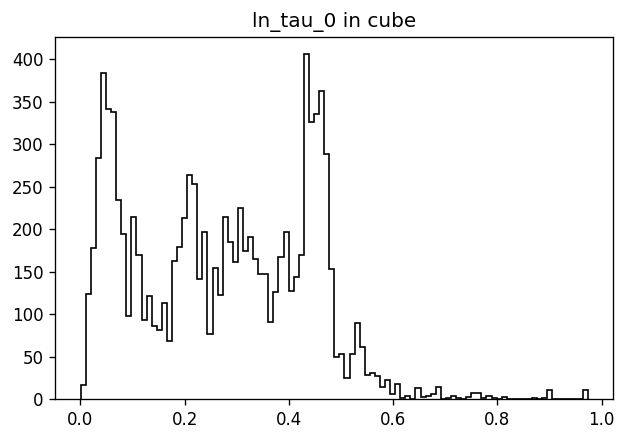

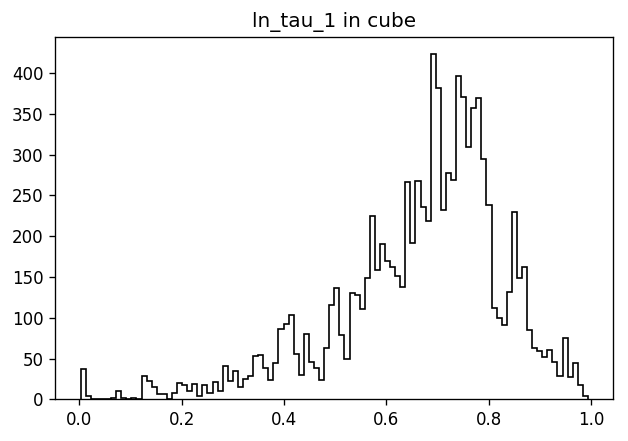

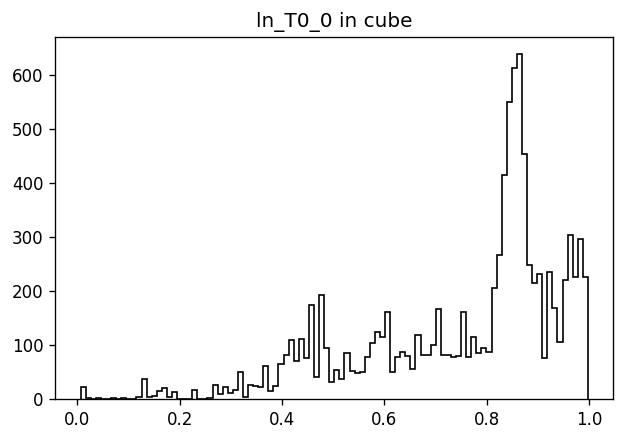

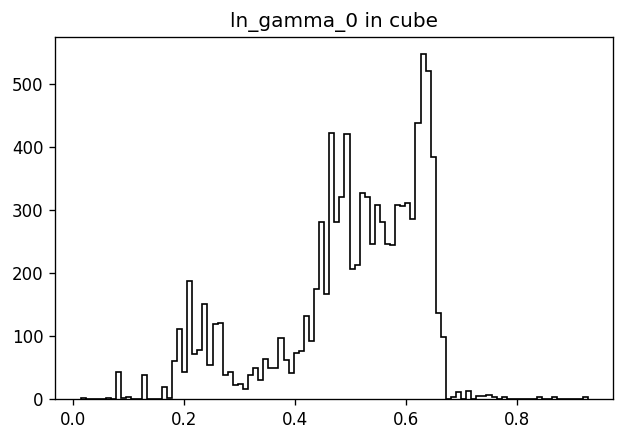

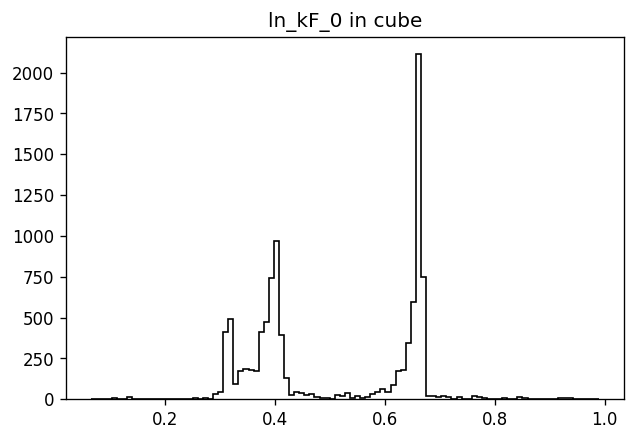

In [18]:
sampler.plot_histograms(cube=True)

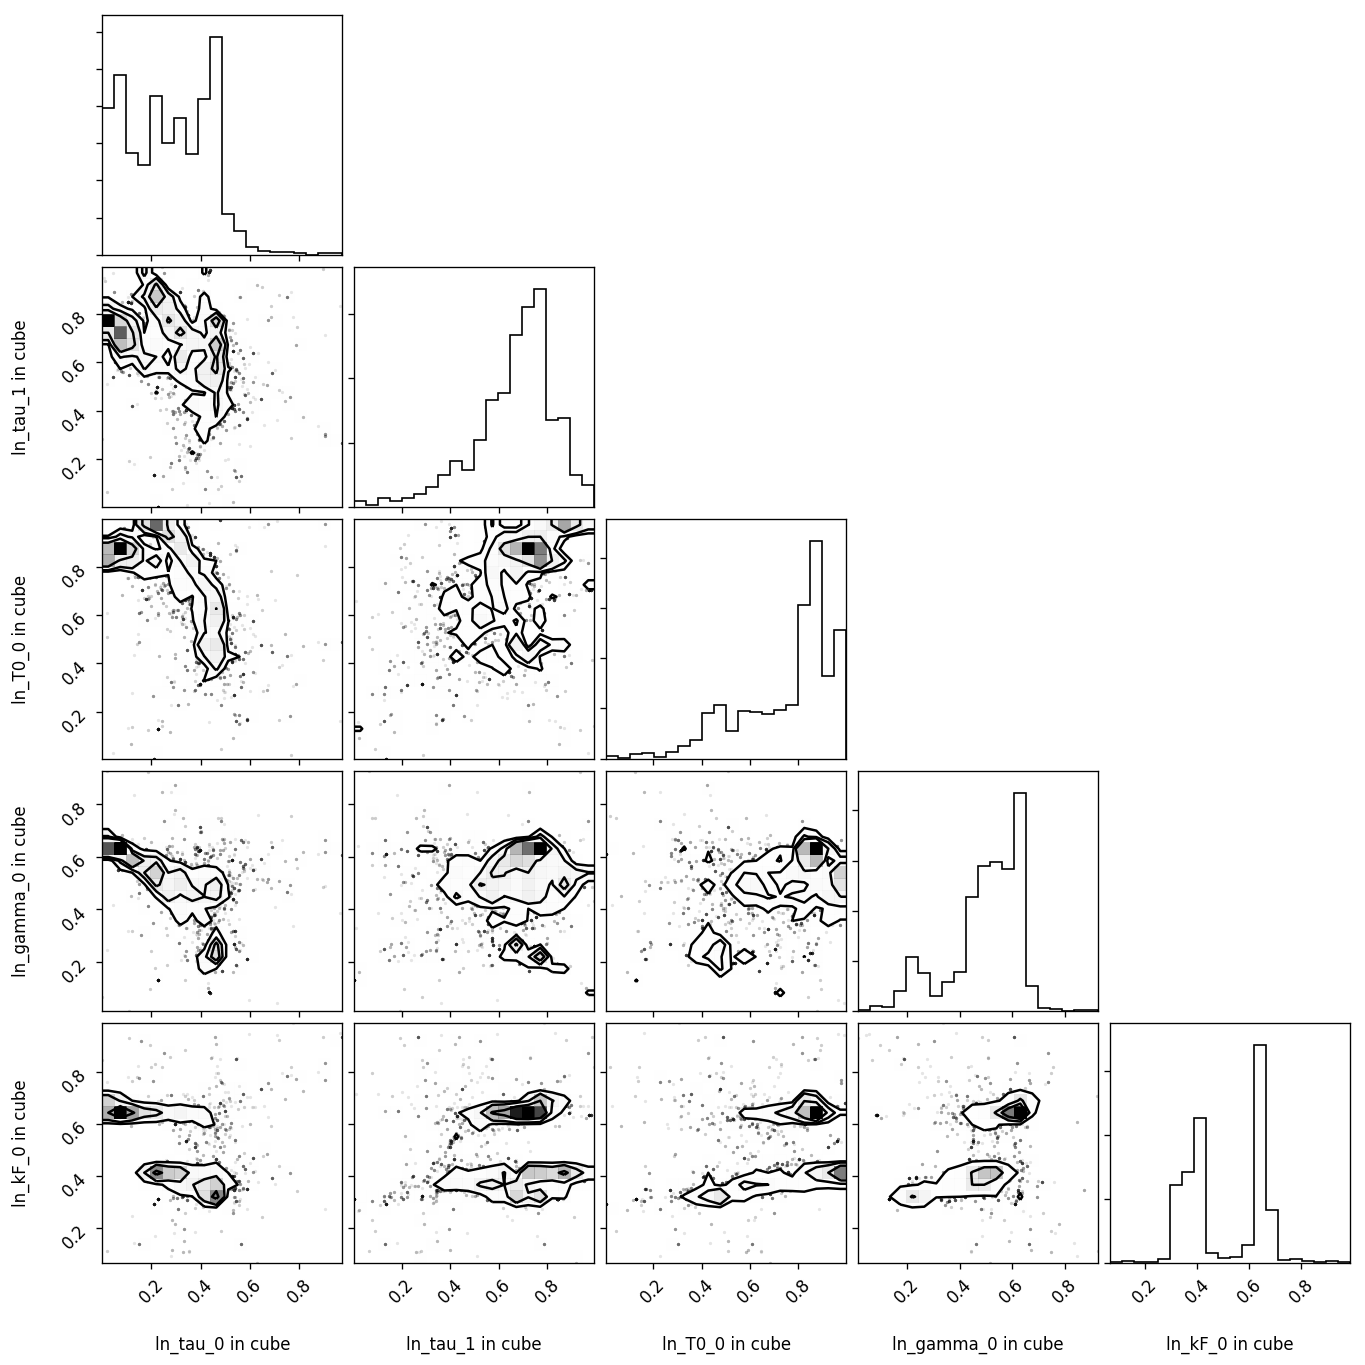

In [19]:
sampler.plot_corner(cube=True)

### Plot results for dimensional parameters

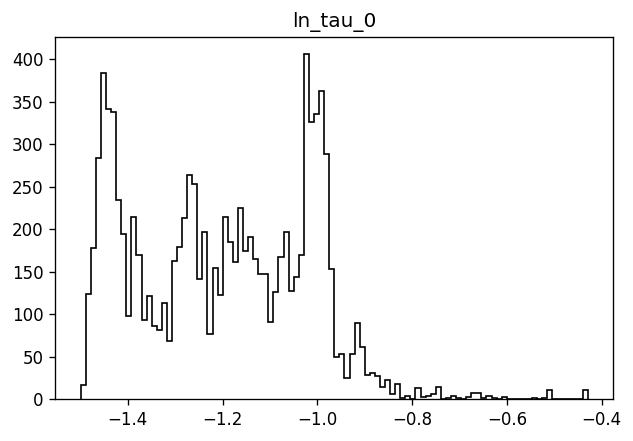

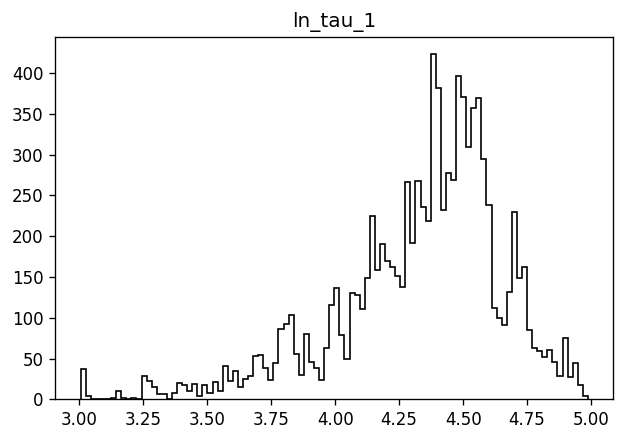

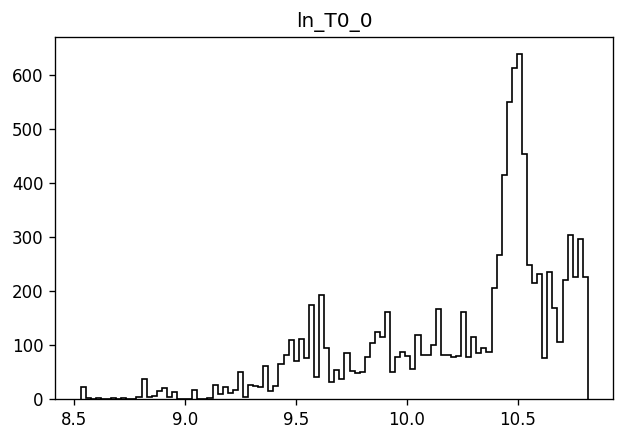

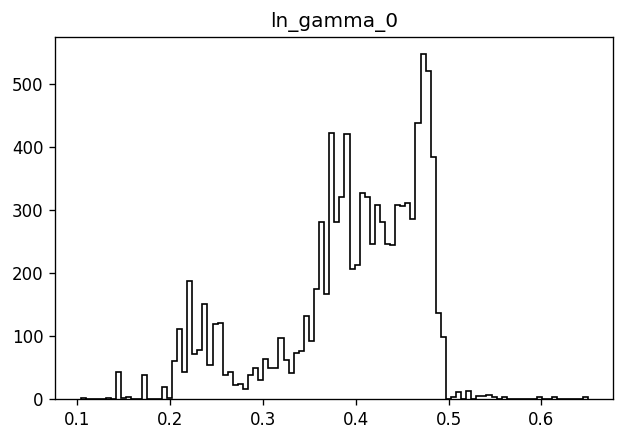

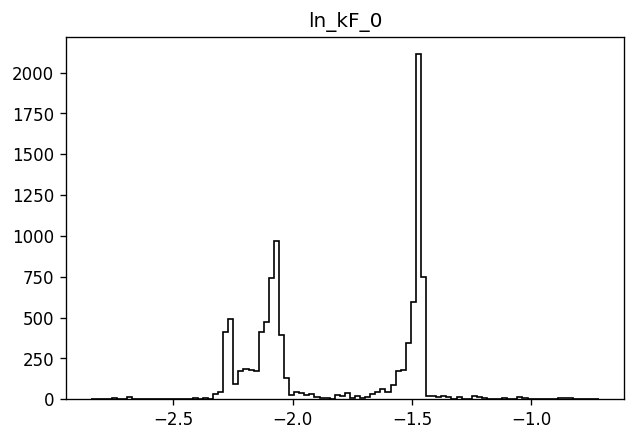

In [20]:
sampler.plot_histograms(cube=False)

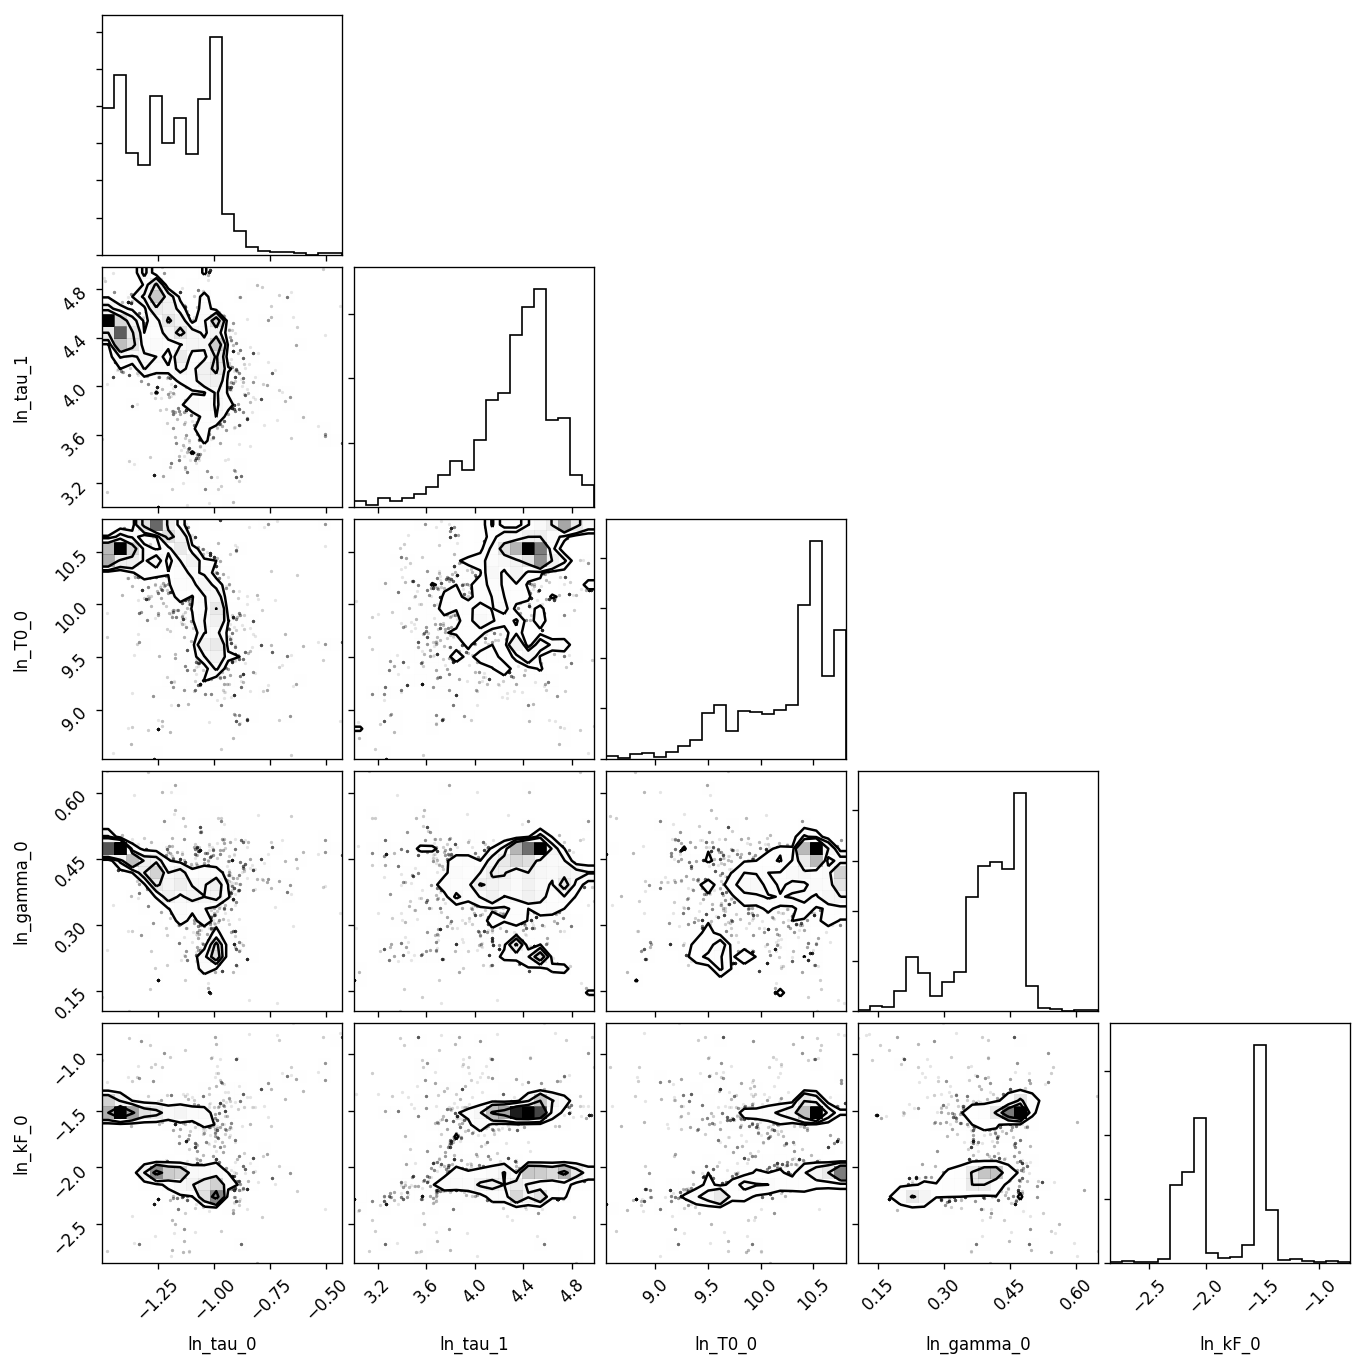

In [21]:
sampler.plot_corner(cube=False)

### Use likelihood object to make other useful plots

In [22]:
# get mean of chain
mcmc_mean=np.mean(sampler.sampler.flatchain,axis=0)
print('mean point',mcmc_mean)

mean point [ 0.27286833  0.66684393  0.75259604  0.50194675  0.50911624]


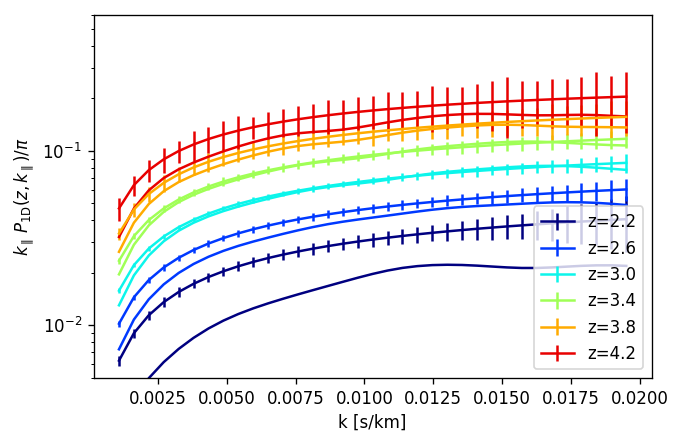

In [23]:
sampler.like.plot_p1d(values=mcmc_mean,plot_every_iz=2)

In [24]:
# get best fit model
ind = np.unravel_index(np.argmax(sampler.sampler.lnprobability, axis=None), sampler.sampler.lnprobability.shape)
best_fit=sampler.sampler.chain[ind]

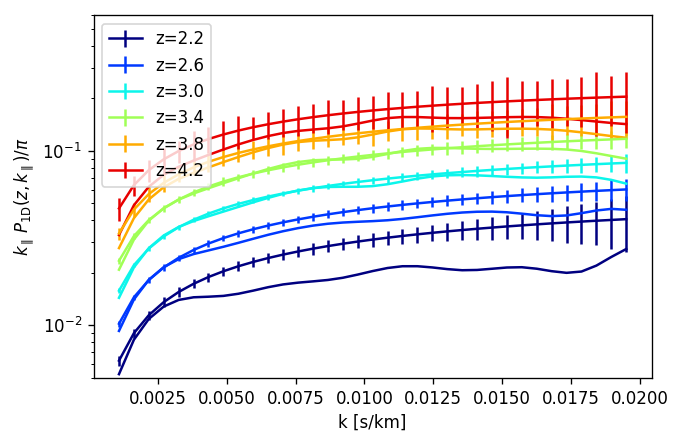

In [25]:
sampler.like.plot_p1d(values=best_fit,plot_every_iz=2)

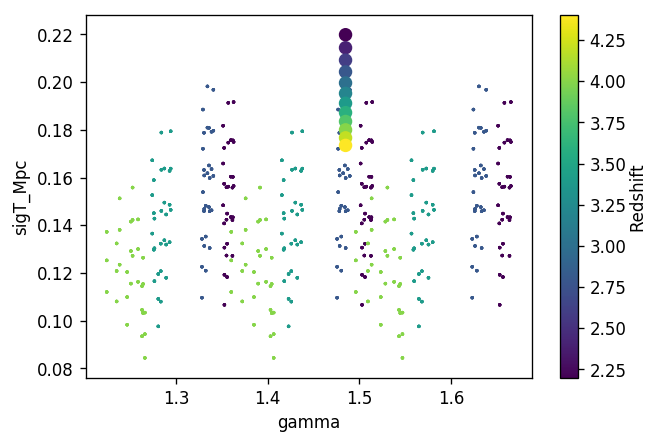

In [26]:
sampler.like.overplot_emulator_calls('gamma','sigT_Mpc',values=mcmc_mean)

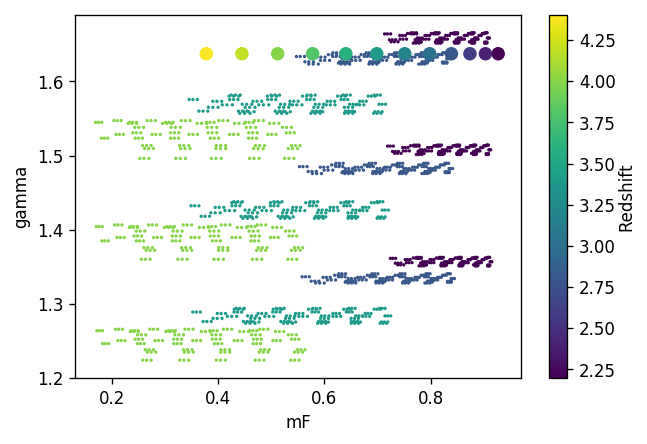

In [27]:
sampler.like.overplot_emulator_calls('mF','gamma',values=best_fit)

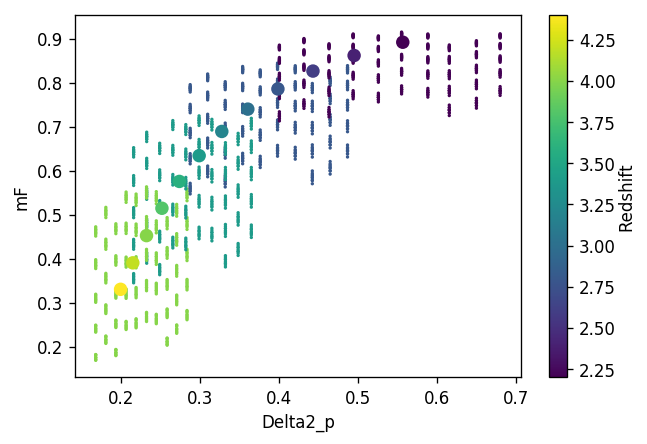

In [28]:
sampler.like.overplot_emulator_calls('Delta2_p','mF',values=mcmc_mean)

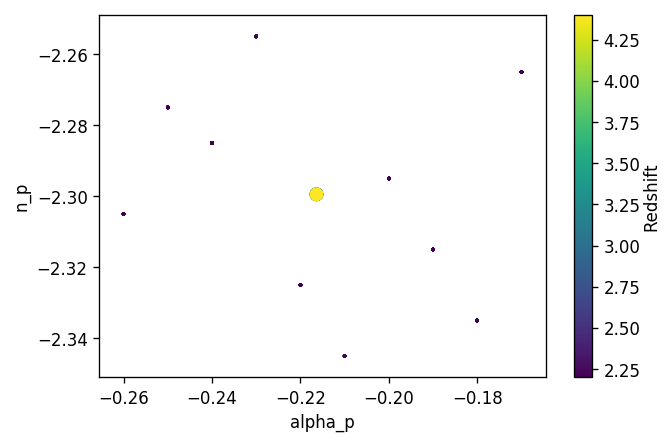

In [29]:
sampler.like.overplot_emulator_calls('alpha_p','n_p',values=mcmc_mean)

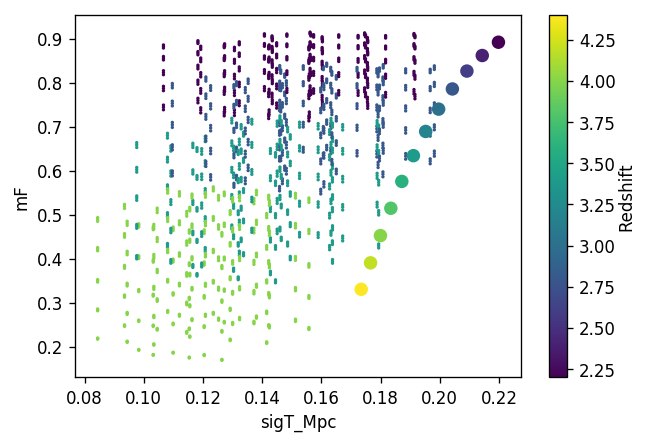

In [30]:
sampler.like.overplot_emulator_calls('sigT_Mpc','mF',values=mcmc_mean)

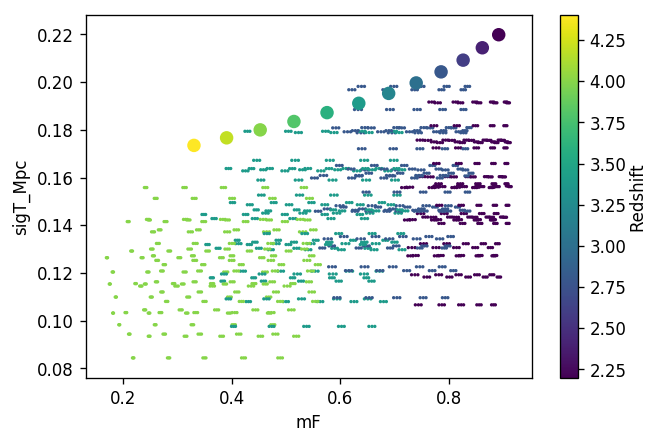

In [31]:
sampler.like.overplot_emulator_calls('mF','sigT_Mpc',values=mcmc_mean)

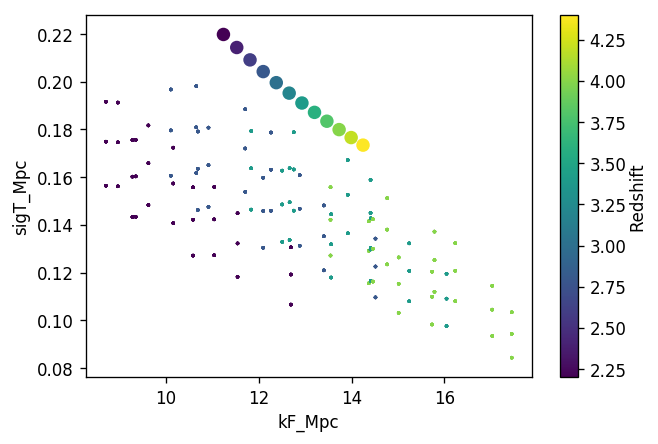

In [32]:
sampler.like.overplot_emulator_calls('kF_Mpc','sigT_Mpc',values=mcmc_mean)

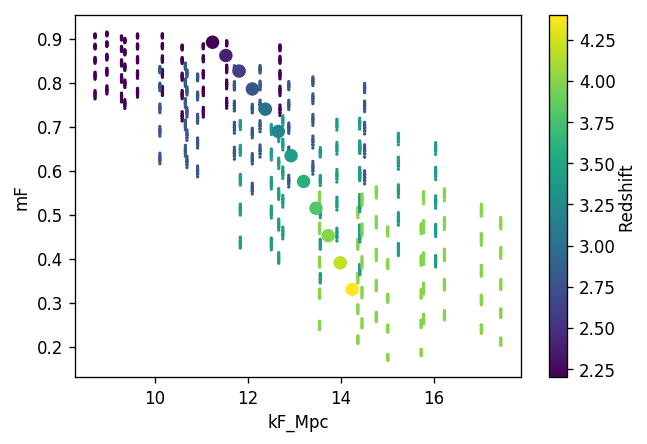

In [33]:
sampler.like.overplot_emulator_calls('kF_Mpc','mF',values=mcmc_mean)

### Write chain to file for later use

In [34]:
chain_filename='test'
sampler.write_chain_to_file(chain_filename)

### Read pre-computed chain

In [35]:
new_sampler = emcee_sampler.EmceeSampler(emulator=emu,free_parameters=free_parameters,
                                         read_chain_file=chain_filename,verbose=True)

use default likelihood
Note: redshifts have been re-sorted (earliest first)
will read chain from file test
done setting up sampler


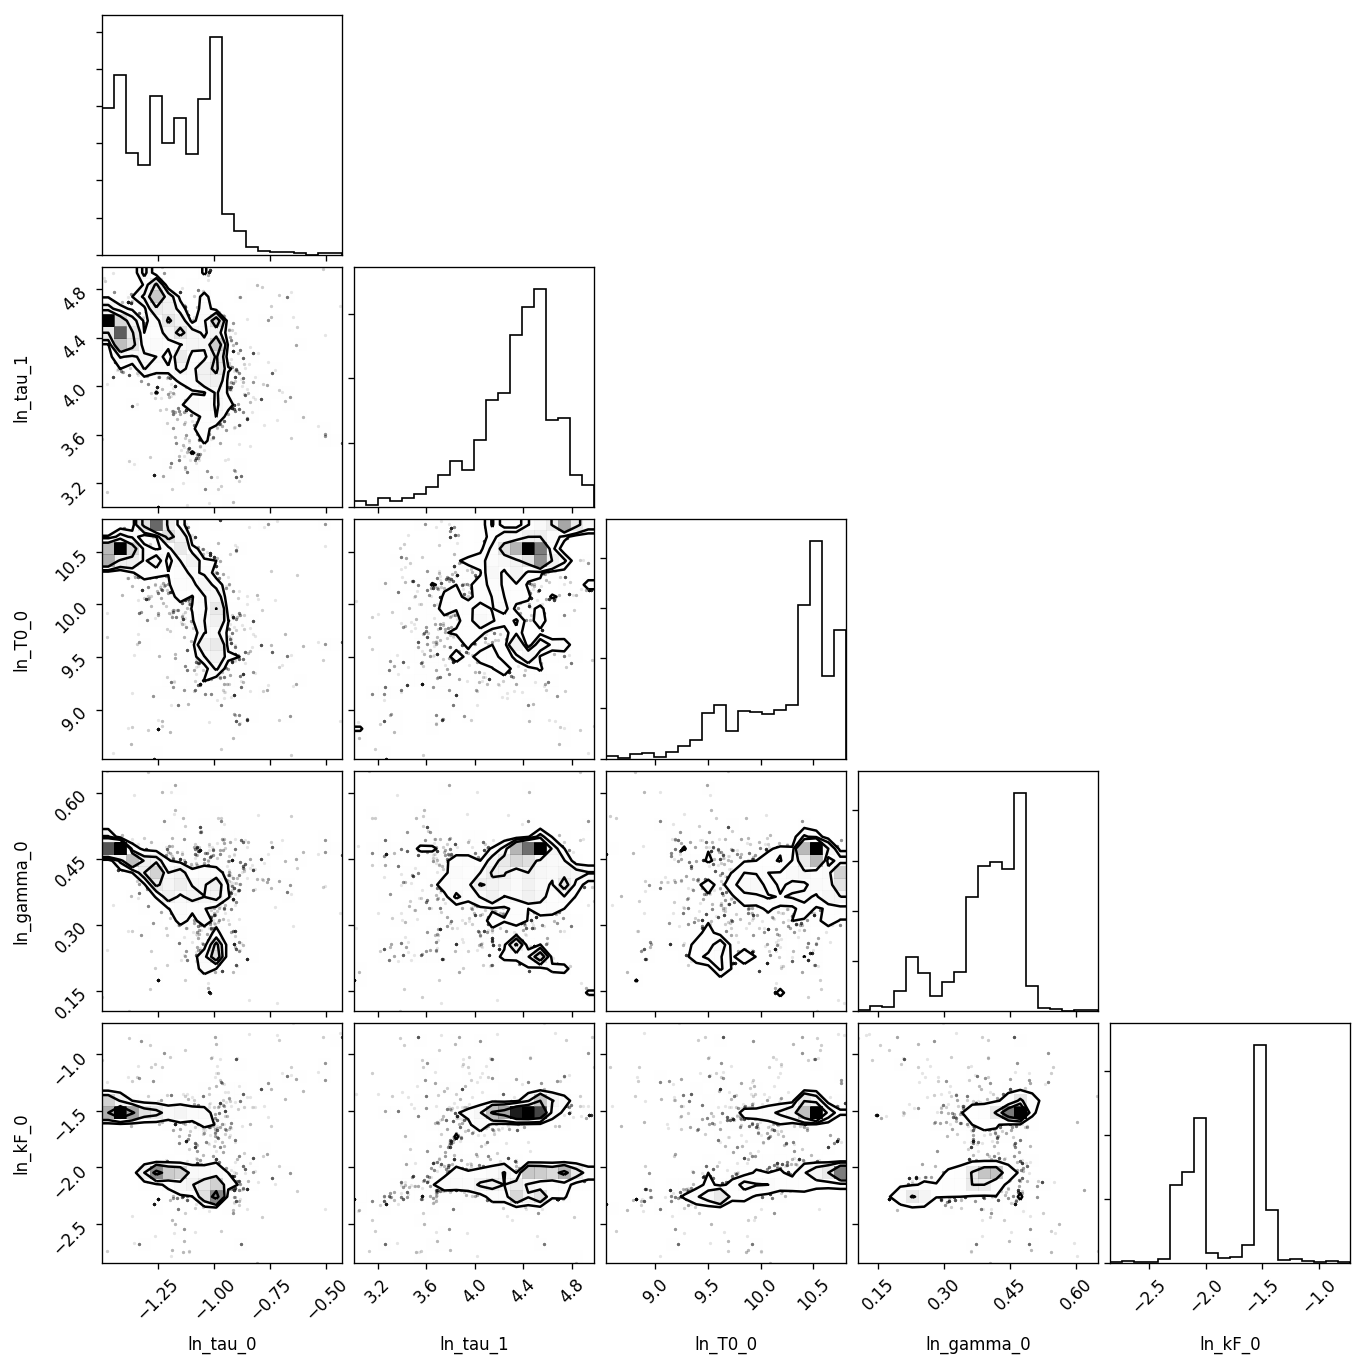

In [36]:
new_sampler.plot_corner(cube=False)

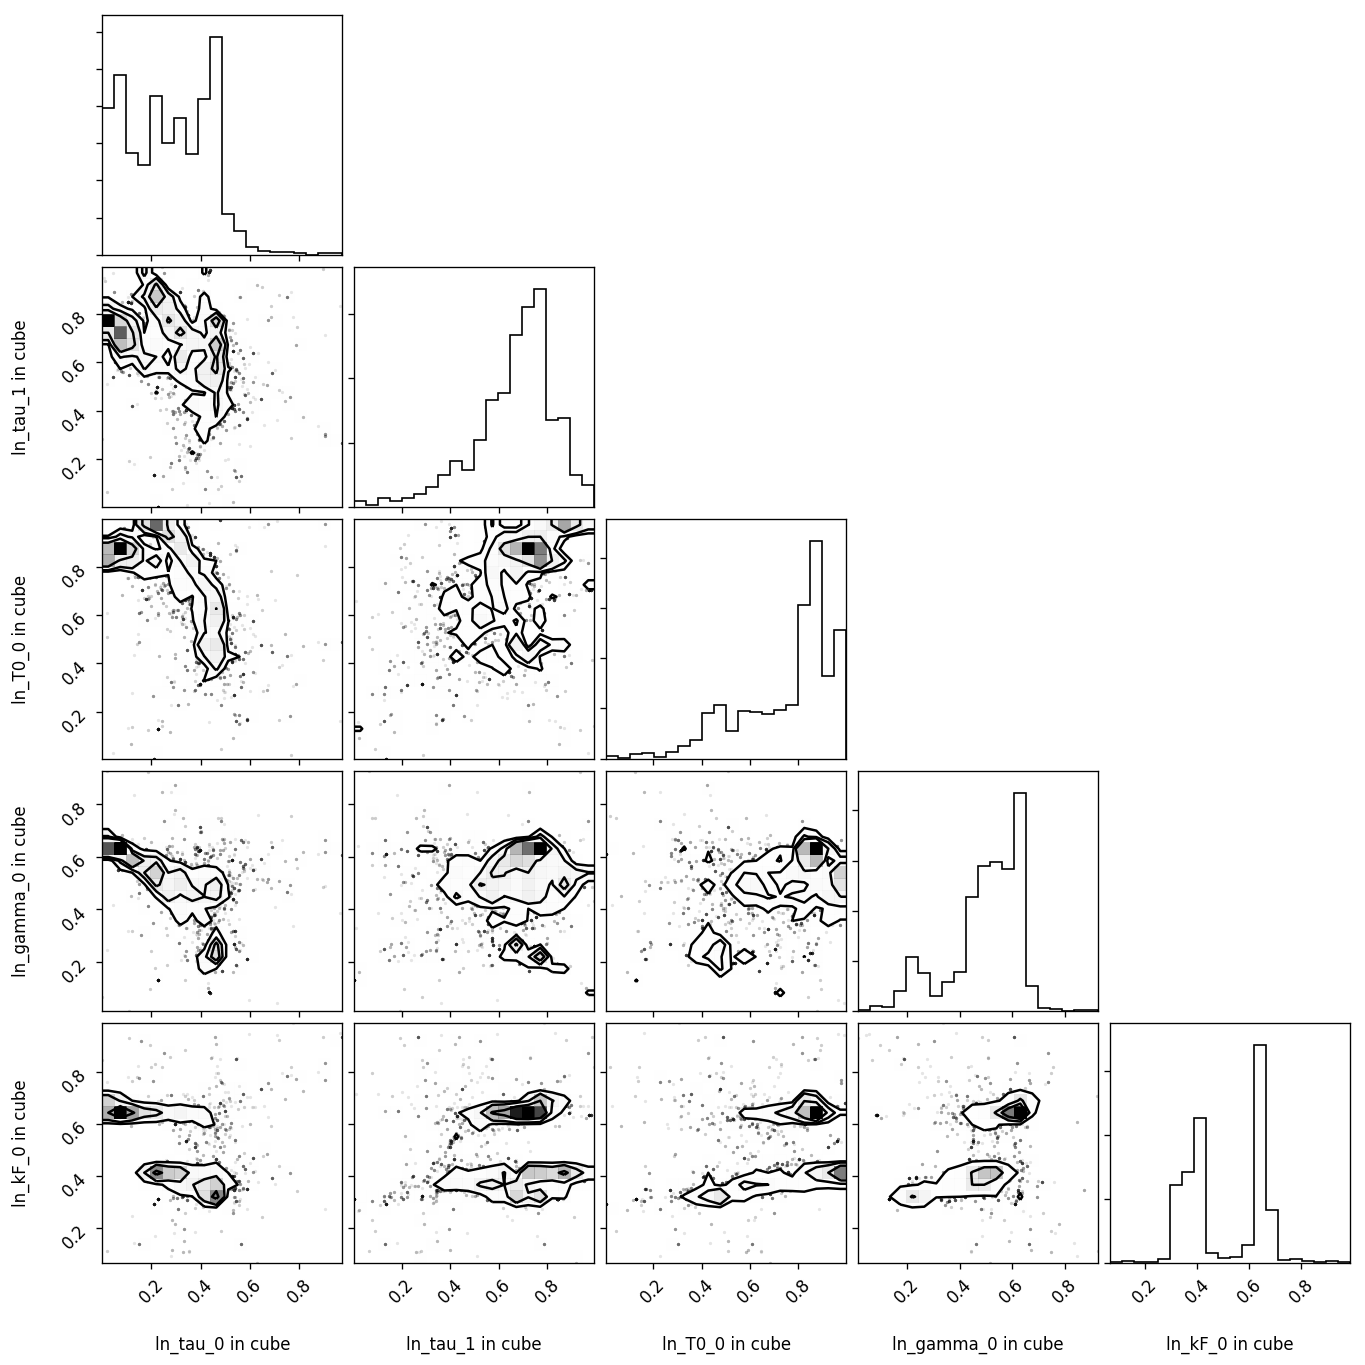

In [37]:
new_sampler.plot_corner(cube=True)

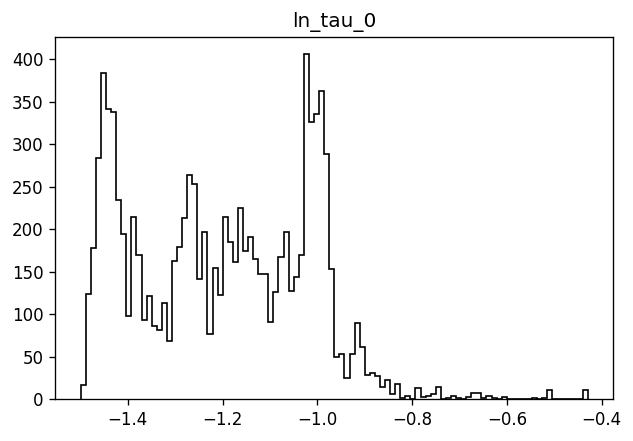

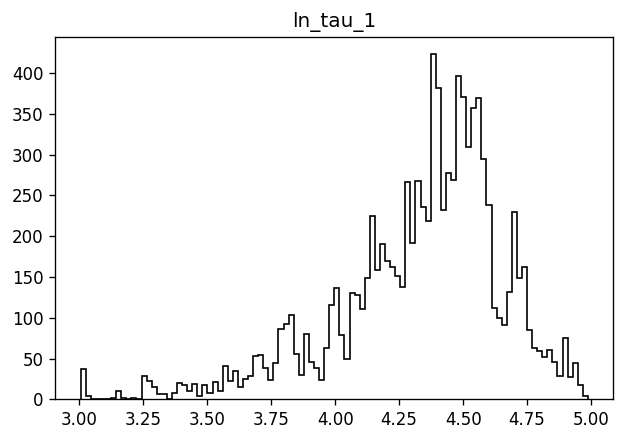

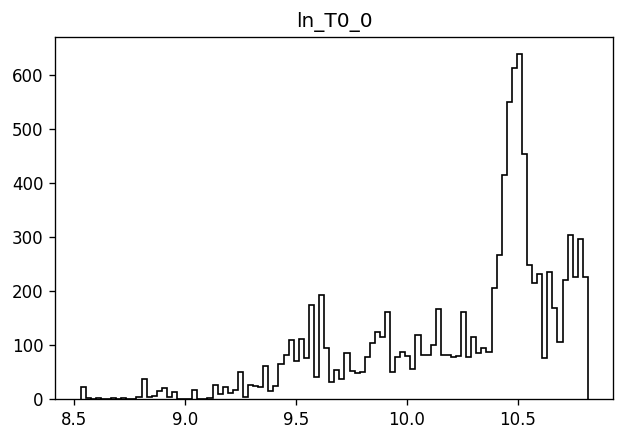

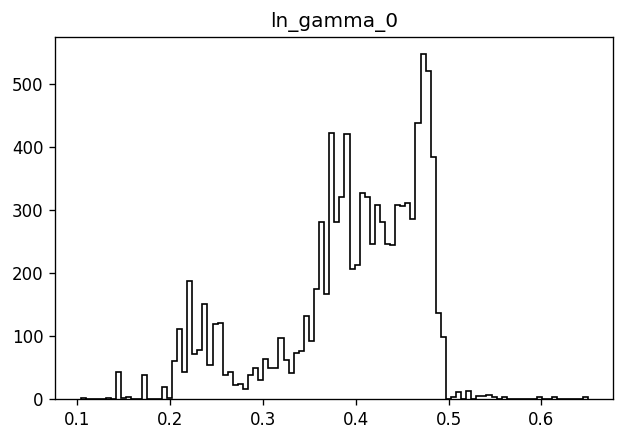

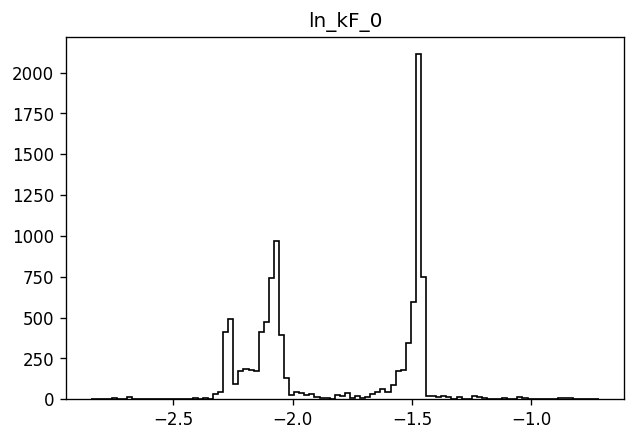

In [38]:
new_sampler.plot_histograms(cube=False)

In [39]:
sampler.sampler.flatlnprobability

array([-24278.43658579, -24278.43658579, -24278.43658579, ...,
        -2325.40019018,  -2325.40019018,  -2325.40019018])